In [1]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

/Users/Rup/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/Users/Rup/anaconda3/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

In [2]:
# Loading in the training data with Pandas
train = pd.read_csv("xid-34549157_1")
test = pd.read_csv("xid-34549156_1")

### 1. The Authors and their works EDA
In this notebook we will apply topic modelling and create three topics as given dataset consists of three authors and the excerpts from their horror stories. These authors are Edgar Allan Poe, Mary Shelley, and HP Lovecraft. Dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. Edgar Allan Poe work is around tales of mystery and the macabre. Mary Shelley work is around science fiction and HP Lovecraft, best known as a writer of weird fiction.

In [3]:
train = train.drop(columns = ['id'], axis=1)
train.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
test = test.drop(columns = ['id'], axis=1)
test.head()

,text
0,"Still, as I urged our leaving Ireland with suc..."
1,"If a fire wanted fanning, it could readily be ..."
2,And when they had broken down the frail door t...
3,While I was thinking how I should possibly man...
4,I am not sure to what limit his knowledge may ...


In [5]:
print("train.shape",train.shape)
print("test.shape",test.shape)

train.shape (19579, 2)
test.shape (8392, 1)


#### The pipeline will be
Documents ===> PreProcessing ===> Vector Space ===> Model (lda/nmf) ===> Evaluation (metrics, visualizations)

# Summary statistics of the training set
Here we can visualize some basic statistics in the data, like the distribution of entries for each author. For this purpose, lets plot some simple bar plots. 

In [6]:
dict1 = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar( x = train.author.map(dict1).unique(),y = train.author.value_counts().values,marker= dict(colorscale="jet",color = train.author.value_counts().values),text='Text data by Author')]
layout = go.Layout(title='The distribution of the articles among the three authors : ')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

#### 
Cleaning/Preparing both Training and Test data. EDA after removing punctuations,unwanted numbers or characters and converting the text to lower case. Also removing the stopwords , the words occuring commonly in all the documents and not adding any value to distinctly identify the three subsets of the given collection of the documents.There are no null columns in this dataset. Also dropping the id column and we will use text data to build our model.


In [7]:
train['text_processed']=train['text'].map(lambda x:re.sub('[,\.!?]','',x))
train['text_processed']=train['text_processed'].map(lambda x:x.lower())
print("training\n" , train['text_processed'].head())
test['text_processed']=test['text'].map(lambda x:re.sub('[,\.!?]','',x))
test['text_processed']=test['text_processed'].map(lambda x:x.lower())
print("testing\n" ,test['text_processed'].head())

training
 0    this process however afforded me no means of a...
1    it never once occurred to me that the fumbling...
2    in his left hand was a gold snuff box from whi...
3    how lovely is spring as we looked from windsor...
4    finding nothing else not even gold the superin...
Name: text_processed, dtype: object
testing
 0    still as i urged our leaving ireland with such...
1    if a fire wanted fanning it could readily be f...
2    and when they had broken down the frail door t...
3    while i was thinking how i should possibly man...
4    i am not sure to what limit his knowledge may ...
Name: text_processed, dtype: object


In [8]:
def cleanText(input_string):
    modified_string=re.sub('[^A-Za-z0-9]+',' ', input_string)
    return(modified_string)
train['text_processed']=train.text_processed.apply(cleanText)
print("training\n",train['text_processed'][0])
test['text_processed']=test.text_processed.apply(cleanText)
print("test\n",test['text_processed'][0])

training
 this process however afforded me no means of ascertaining the dimensions of my dungeon as i might make its circuit and return to the point whence i set out without being aware of the fact so perfectly uniform seemed the wall
test
 still as i urged our leaving ireland with such inquietude and impatience my father thought it best to yield


In [9]:
nltk.download('stopwords')
stopWords=stopwords.words('english')
stopWords.extend(["make","mr","de","without","let","rather","upon","within","made","must","much","yet","thought","see","said","us","say","whose","though","every","know","many","will","never","even","found","might","almost","although","indeed","thus","still","this","me","of","may","would","ever","could","shall","come","go","soon","however","become","give","take","well"])
def removeStopWords(stopWords,rvw_txt):
    newtxt=' '.join([word for word in rvw_txt.split() if word not in stopWords])
    return newtxt
train['text_processed']=[removeStopWords(stopWords,x) for x in train['text_processed']]
test['text_processed']=[removeStopWords(stopWords,x) for x in test['text_processed']]
                   

[nltk_data] Downloading package stopwords to /Users/Rup/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### WordClouds to visualise the corpus

In [10]:
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

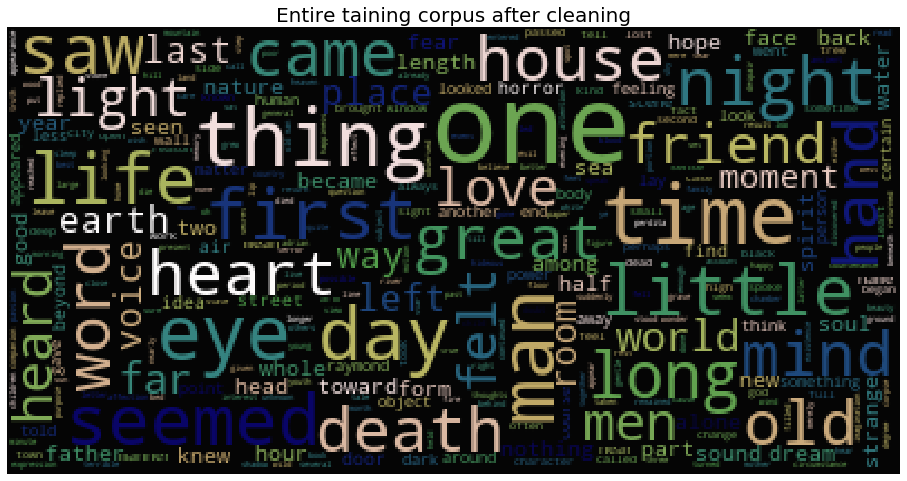

In [11]:
# wordcloud for the entire training corpus
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 50)
wc.generate(" ".join(train["text_processed"].values))
plt.title("Entire taining corpus after cleaning", fontsize=20)
plt.imshow(wc.recolor( colormap= 'gist_earth' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

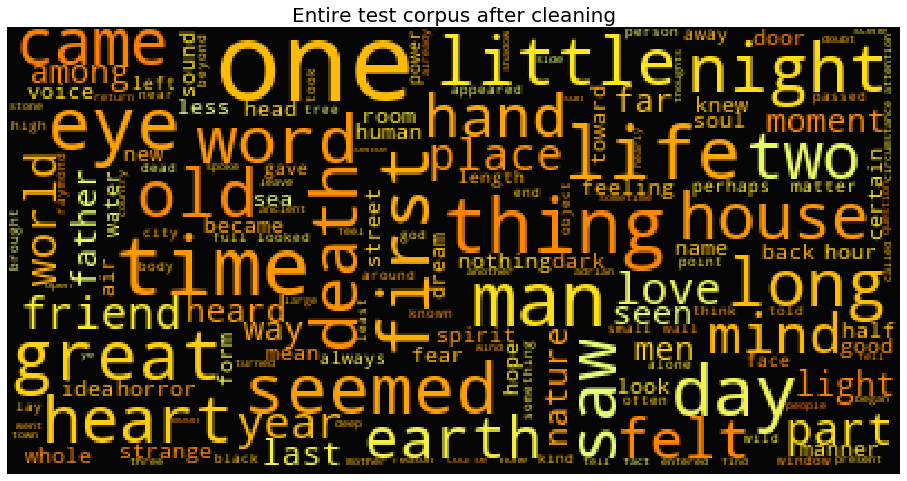

In [12]:
# wordcloud for the entire test corpus
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 50)
wc.generate(" ".join(test["text_processed"].values))
plt.title("Entire test corpus after cleaning", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Wistia' , random_state=17), alpha=0.98)
plt.axis('off')

#### 
The words like thought, eye, life, old, time, earth, house, fear, love, death, dream etc can be observed.

In [13]:
words = train['text_processed'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = words.index.values[2:50],y = words.values[2:50],marker= dict(colorscale='algae',color = words.values[2:100]),text="Frequency")]
layout = go.Layout(title='Top 50 words in the training corpus after cleaning')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bargraph')

In [14]:
words = test['text_processed'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = words.index.values[2:50],y = words.values[2:50],marker= dict(colorscale='rdgy',color = words.values[2:100]),text="Frequency")]
layout = go.Layout(title='Top 50 words in the test corpus after cleaning')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bargraph')

#### 
The words like time,old,first,life, etc are the trending words in the corpus.
Our training and test corpus have similar top frequency words.

In [15]:
hpl = train[train.author=="HPL"]["text_processed"].values
eap = train[train.author=="EAP"]["text_processed"].values
mws = train[train.author=="MWS"]["text_processed"].values

#### Howard Phillips Lovecraft was an American writer of weird, science, fantasy, and horror fiction.

(-0.5, 399.5, 199.5, -0.5)

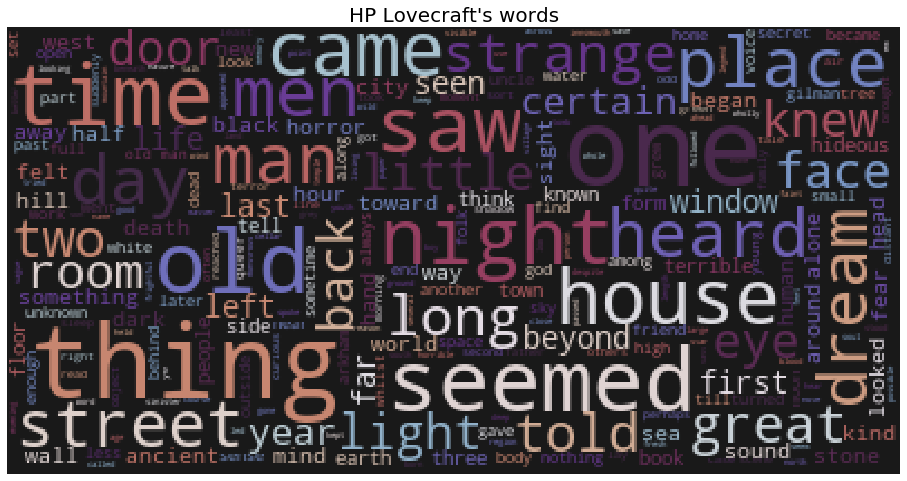

In [16]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 50)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft's words", fontsize=20)
plt.imshow(wc.recolor( colormap= 'twilight' , random_state=17), alpha=0.9)
plt.axis('off')

In [17]:
words_HPL = train[train.author=="HPL"]["text_processed"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = words_HPL.index.values[2:50],y = words_HPL.values[2:50],marker= dict(colorscale='earth',color = words_HPL.values[2:100]),text="Frequency")]
layout = go.Layout(title='Top 50 words of HPL')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bargraph')

#### Edgar Allan Poe was an American writer, poet, editor, and literary critic. Poe is best known for his poetry and short stories, particularly his tales of mystery and the macabre. He is widely regarded as a central figure of Romanticism in the United States, and of American literature.

(-0.5, 399.5, 199.5, -0.5)

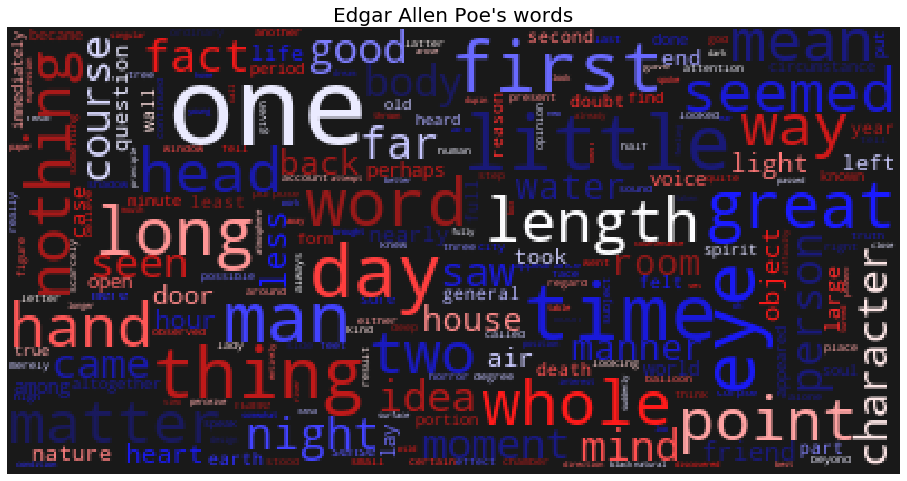

In [18]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000,  stopwords=STOPWORDS, max_font_size= 50)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe's words",fontsize=20)
plt.imshow(wc.recolor( colormap= 'seismic_r' , random_state=17), alpha=0.9)
plt.axis('off')

In [19]:
words_EAP = train[train.author=="EAP"]["text_processed"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = words_EAP.index.values[2:50],y = words_EAP.values[2:50],marker= dict(colorscale='tealrose',color = words_EAP.values[2:100]),text="Frequency")]
layout = go.Layout(title='Top 50 words of EAP')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bargraph')

#### Mary Wollstonecraft Shelley was an English novelist who wrote the Gothic novel Frankenstein; or, The Modern Prometheus, which is considered an early example of science fiction.

(-0.5, 399.5, 199.5, -0.5)

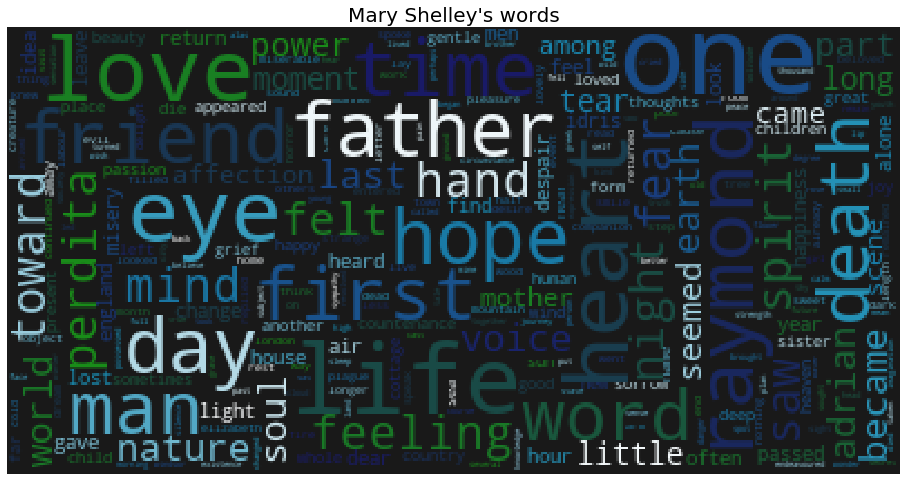

In [20]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 50)
wc.generate(" ".join(mws))
plt.title("Mary Shelley's words", fontsize= 20)
plt.imshow(wc.recolor( colormap= 'ocean_r' , random_state=17), alpha=0.9)
plt.axis('off')

In [21]:
words_MWS = train[train.author=="MWS"]["text_processed"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(x = words_MWS.index.values[2:50],y = words_MWS.values[2:50],marker= dict(colorscale='delta',color = words_MWS.values[2:100]),text="Frequency")]
layout = go.Layout(title='Top 50 words of MWS')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bargraph')

#### Applying text processing methods such as tokenization, stop word removal, stemming, and vectorizing text via term frequencies (TF) as well as the inverse document frequencies (TF-IDF).

In [22]:
lemm = WordNetLemmatizer()
class LemmaTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaTfidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [23]:
train_text = list(train.text_processed.values)
test_text = list(test.text_processed.values)
tfidf = LemmaTfidfVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     norm='l1',
                                     decode_error='ignore')
dtm_train = tfidf.fit_transform(train_text) 
dtm_test = tfidf.transform(test_text)

In [24]:
nmf_model = NMF(n_components=3,random_state=43,init="nndsvd",solver="cd",max_iter=500,alpha=0.0, l1_ratio=0.0,beta_loss='frobenius',tol=0.0001)
nmf_model.fit(dtm_train)
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 50 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-50:]])
    print('\n')   


THE TOP 50 WORDS FOR TOPIC #0
['fell', 'intuition', 'world', 'endured', 'observe', 'old', 'like', 'peculiar', 'absolutely', 'sight', 'similar', 'change', 'somewhat', 'pretty', 'bad', 'suspected', 'hell', 'men', 'little', 'happy', 'annoyed', 'sensation', 'told', 'read', 'tell', 'sort', 'strange', 'state', 'heard', 'unknown', 'seen', 'going', 'speaks', 'great', 'funny', 'earth', 'style', 'stand', 'investigation', 'proved', 'method', 'profound', 'line', 'curious', 'particular', 'easily', 'simple', 'try', 'yes', 'thing']


THE TOP 50 WORDS FOR TOPIC #1
['looked', 'told', 'better', 'room', 'dream', 'hope', 'moment', 'went', 'far', 'father', 'light', 'return', 'perdita', 'mind', 'think', 'change', 'matter', 'heart', 'hand', 'raymond', 'tell', 'world', 'left', 'good', 'hour', 'old', 'mean', 'seen', 'passed', 'place', 'friend', 'little', 'word', 'like', 'year', 'death', 'house', 'long', 'eye', 'life', 'felt', 'fear', 'love', 'heard', 'knew', 'came', 'day', 'time', 'night', 'saw']


THE TOP 50 

In [25]:
topic_results_test_nmf = nmf_model.transform(dtm_test)

In [26]:
topic_results_test_nmf.argmax(axis=1)
test['Topic_NMF'] = topic_results_test_nmf.argmax(axis=1)

In [27]:
lda = LatentDirichletAllocation(n_components=3, max_iter=100
                                ,random_state = 14)

In [28]:
lda.fit(dtm_train)

LatentDirichletAllocation(max_iter=100, n_components=3, random_state=14)

In [29]:
for index,topic in enumerate(lda.components_):
    print(f'THE TOP 40 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-40:]])
    print('\n')   

THE TOP 40 WORDS FOR TOPIC #0
['believe', 'felt', 'young', 'lost', 'present', 'better', 'spirit', 'think', 'fact', 'god', 'soul', 'little', 'good', 'child', 'return', 'perdita', 'long', 'tell', 'feeling', 'nature', 'great', 'idea', 'fear', 'father', 'hope', 'matter', 'mean', 'raymond', 'world', 'mind', 'love', 'day', 'heart', 'friend', 'death', 'year', 'word', 'time', 'man', 'life']


THE TOP 40 WORDS FOR TOPIC #1
['dark', 'quite', 'lay', 'arm', 'went', 'looked', 'sea', 'right', 'city', 'wall', 'street', 'water', 'day', 'foot', 'little', 'sound', 'time', 'face', 'window', 'took', 'body', 'place', 'head', 'length', 'way', 'left', 'light', 'door', 'room', 'seen', 'thing', 'old', 'heard', 'eye', 'hand', 'like', 'house', 'came', 'saw', 'night']


THE TOP 40 WORDS FOR TOPIC #2
['attempt', 'fly', 'forgotten', 'brief', 'bear', 'sort', 'try', 'dr', 'write', 'reality', 'mystery', 'tried', 'party', 'vain', 'changed', 'madness', 'business', 'perceive', 'story', 'servant', 'hideous', 'altogether',

In [30]:
topic_results_test_lda = lda.transform(dtm_test)

In [31]:
topic_results_test_lda.argmax(axis=1)
test['Topic_LDA'] = topic_results_test_lda.argmax(axis=1)

In [32]:
test.head(50)

,text,text_processed,Topic_NMF,Topic_LDA
0,"Still, as I urged our leaving Ireland with suc...",urged leaving ireland inquietude impatience fa...,1,0
1,"If a fire wanted fanning, it could readily be ...",fire wanted fanning readily fanned newspaper g...,1,1
2,And when they had broken down the frail door t...,broken frail door two cleanly picked human ske...,1,1
3,While I was thinking how I should possibly man...,thinking possibly manage one actually tumbled ...,1,1
4,I am not sure to what limit his knowledge may ...,sure limit knowledge extend,1,0
5,"""The thick and peculiar mist, or smoke, which ...",thick peculiar mist smoke distinguishes indian...,1,1
6,"That which is not matter, is not at all unless...",matter unless qualities things,0,0
7,I sought for repose although I did not hope fo...,sought repose hope forgetfulness knew pursued ...,1,0
8,"Upon the fourth day of the assassination, a pa...",fourth day assassination party police came une...,1,1
9,"""The tone metaphysical is also a good one.",tone metaphysical also good one,1,0


In [33]:
#LDA topics extracting
first_topic_LDA = lda.components_[0]
second_topic_LDA = lda.components_[1]
third_topic_LDA = lda.components_[2]


first_topic_LDA_words = [tfidf.get_feature_names_out()[i] for i in first_topic_LDA.argsort()[:-50 - 1 :-1]]
second_topic_LDA_words = [tfidf.get_feature_names_out()[i] for i in second_topic_LDA.argsort()[:-50 - 1 :-1]]
third_topic_LDA_words = [tfidf.get_feature_names_out()[i] for i in third_topic_LDA.argsort()[:-50 - 1 :-1]]


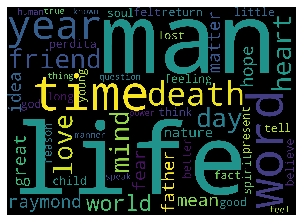

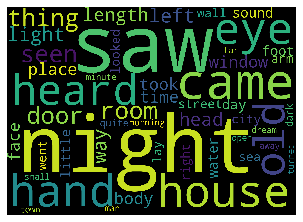

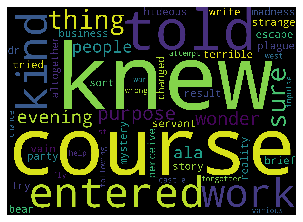

In [34]:
#plotting the topics discovered by LDA
plt.figure(figsize=(16,13))
firstcloud_LDA = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_LDA_words))
secondcloud_LDA = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_LDA_words))
thirdcloud_LDA = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_LDA_words))
plt.subplot(3, 1, 1)
plt.imshow(firstcloud_LDA)
plt.axis('off')
plt.show()
plt.figure(figsize=(16,13))
plt.subplot(3, 1, 2)
plt.imshow(secondcloud_LDA)
plt.axis('off')
plt.show()
plt.figure(figsize=(16,13))
plt.subplot(3, 1, 3)
plt.imshow(thirdcloud_LDA)
plt.axis('off')
plt.show()



In [35]:
#NMF topics extracting
first_topic_nmf = nmf_model.components_[0]
second_topic_nmf = nmf_model.components_[1]
third_topic_nmf = nmf_model.components_[2]


first_topic_nmf_words = [tfidf.get_feature_names_out()[i] for i in first_topic_nmf.argsort()[:-50 - 1 :-1]]
second_topic_nmf_words = [tfidf.get_feature_names_out()[i] for i in second_topic_nmf.argsort()[:-50 - 1 :-1]]
third_topic_nmf_words = [tfidf.get_feature_names_out()[i] for i in third_topic_nmf.argsort()[:-50 - 1 :-1]]



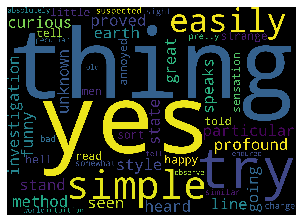

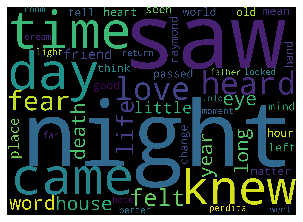

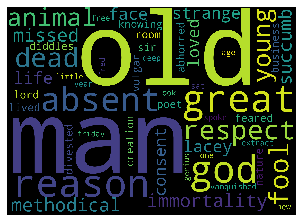

In [36]:
#plotting the topics discovered by NMF
plt.figure(figsize=(16,13))
firstcloud_nmf = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_nmf_words))
secondcloud_nmf = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_nmf_words))
thirdcloud_nmf = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_nmf_words))
plt.subplot(3, 1, 1)
plt.imshow(firstcloud_nmf)
plt.axis('off')
plt.show()
plt.figure(figsize=(16,13))
plt.subplot(3, 1, 2)
plt.imshow(secondcloud_nmf)
plt.axis('off')
plt.show()
plt.figure(figsize=(16,13))
plt.subplot(3, 1, 3)
plt.imshow(thirdcloud_nmf)
plt.axis('off')
plt.show()



#### "id02310"
"Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield."

Gold label is-  Mary Wollstonecraft Shelley: Frankenstein.

LDA predicted topic 0
NMF predicted topic 1
If we put LDA topic 0  and NMF topic 1 side by side, they are included in the top 50 most frequency words of Mary Wollstonecraft Shelley's words like 'father','Raymond','spirit','death,'voice','soul','nature',etc.


#####"id24541","If a fire wanted fanning, it could readily be fanned with a newspaper, and as the government grew weaker, I have no doubt that leather and iron acquired durability in proportion, for, in a very short time, there was not a pair of bellows in all Rotterdam that ever stood in need of a stitch or required the assistance of a hammer."

Gold label is-  Edgar Allen Poe

LDA predicted topic 1
NMF predicted topic 1
If we see LDA topic 1 ,  it includes the top 50 most frequency words of Edgar Allen Poe's words like 'doubt','water','door','room','day','night','hand','eyes','head','body','light'-> LDA is right, NMF is not.

"id27757","While I was thinking how I should possibly manage without them, one actually tumbled out of my head, and, rolling down the steep side of the steeple, lodged in the rain gutter which ran along the eaves of the main building."

Gold label is-  The Works of Edgar Allan Poe by Edgar Allan Poe

LDA predicted topic 1
NMF predicted topic 1

LDA is right again but NMF is not.




In [37]:
pyLDAvis.sklearn.prepare(lda,dtm_train,tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.116972 -0.038853       1        1  39.455713
1     -0.105096 -0.053704       2        1  38.112639
2     -0.011877  0.092557       3        1  22.431648, topic_info=          Term       Freq      Total Category  logprob  loglift
6875      knew  19.000000  19.000000  Default  30.0000  30.0000
8128     night  24.000000  24.000000  Default  29.0000  29.0000
10574      saw  22.000000  22.000000  Default  28.0000  28.0000
2662    course  12.000000  12.000000  Default  27.0000  27.0000
7126      life  22.000000  22.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
7993   mystery   4.804700   5.321773   Topic3  -6.8146   1.3925
13591   wonder   7.971539   8.838527   Topic3  -6.3083   1.3915
8784    people   7.927834   9.270478   Topic3  -6.3138   1.3382
11597  strange   7.456111  13.818060   Topic3  -6.3752   0.8778
12195    thing   8.650574  33.370330   Topic3  -6.2266   0.1447

[145 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
342        3  0.988611         ala
421        3  0.905943  altogether
681        2  0.919628         arm
1158       1  1.001254     believe
1225       1  0.985208      better
...      ...       ...         ...
13614      3  0.932246        work
13620      1  0.944928       world
13667      3  0.998871       write
13705      1  0.977215        year
13730      1  0.994253       young

[130 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

###### 
pyLDAvis topic IDs doesn't correspond to sklearn LDA topic IDs ...
 Topic1 -   MWS
 Topic2 <===> EAP 
 Topic3 <===> HPL   